# Disaggregation of appliances from generated load profiles

## Open questions:
- Does an appliance count as 'on' if it is active at _any_ time within a given window?

In [1]:
# General libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Scripts
import utils

pd.set_option("display.precision", 10)
pd.set_option("display.max_columns", 500)

%matplotlib inline

In [2]:
# Constants
DATA_PATH = "data/test"
MODEL_PATH = "models/" + DATA_PATH.split("/")[-1]

In [3]:
df = pd.read_csv(f"{DATA_PATH}/data_reduced.csv", index_col=0)
df

,Electricity.Timestep,Time,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine,Power
0,0,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-01-01 00:00:01,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-01-01 00:00:02,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-01-01 00:00:03,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-01-01 00:00:04,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1048570,1048570,2021-01-13 03:16:10,0.0,0.0,0.0,0.0,0.0,0.0
1048571,1048571,2021-01-13 03:16:11,0.0,0.0,0.0,0.0,0.0,0.0
1048572,1048572,2021-01-13 03:16:12,0.0,0.0,0.0,0.0,0.0,0.0
1048573,1048573,2021-01-13 03:16:13,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
appliances = ["Stove", "Coffee_machine", "Microwave", "Dishwasher", "Washing_machine"]

<AxesSubplot:>

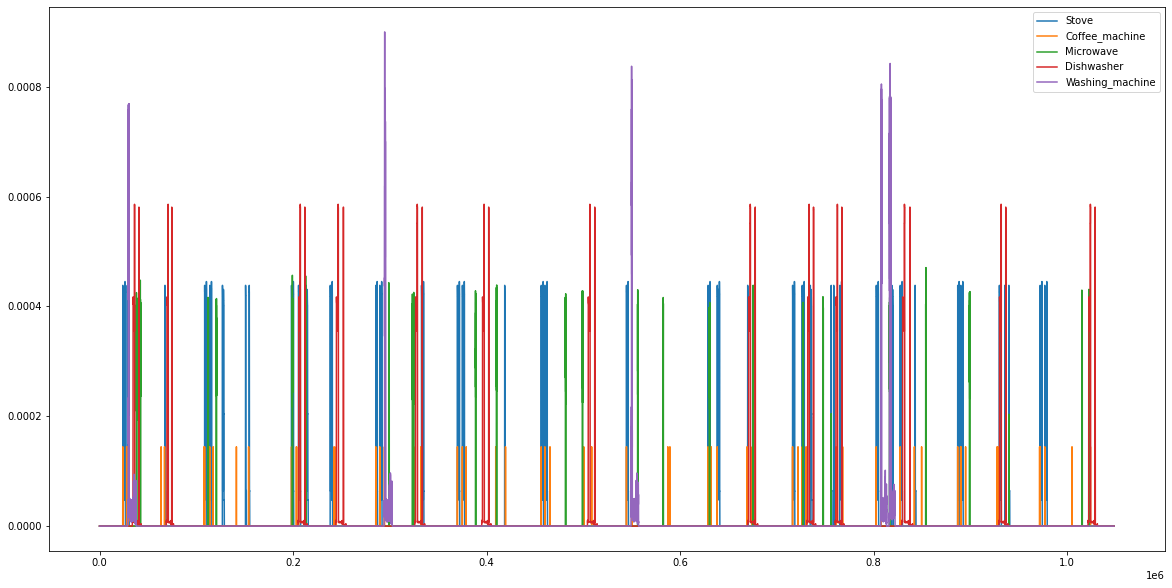

In [5]:
df.plot(y=appliances, figsize=(20, 10))

<AxesSubplot:>

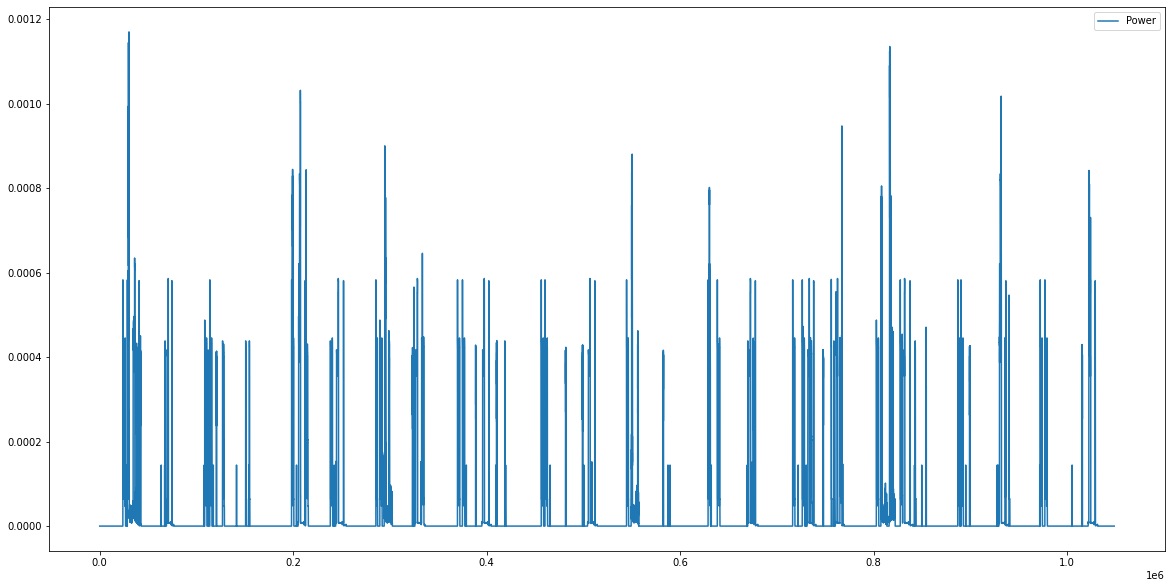

In [6]:
df.plot(y=["Power"], figsize=(20, 10))

<AxesSubplot:>

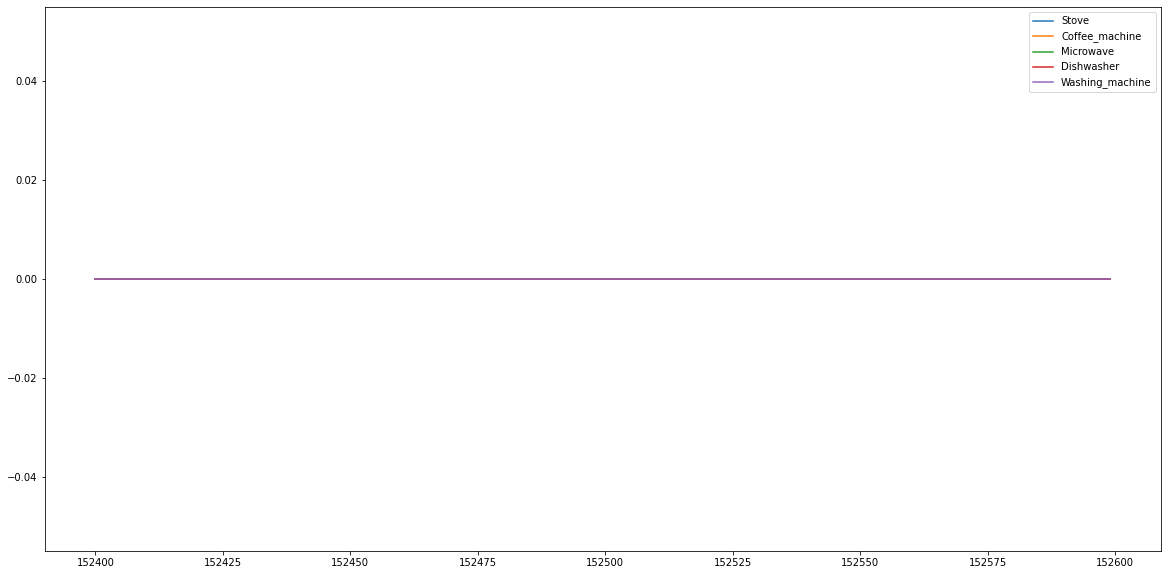

In [7]:
## microwave profile
df.iloc[152400:152600].plot(y=appliances, figsize=(20, 10))

<AxesSubplot:>

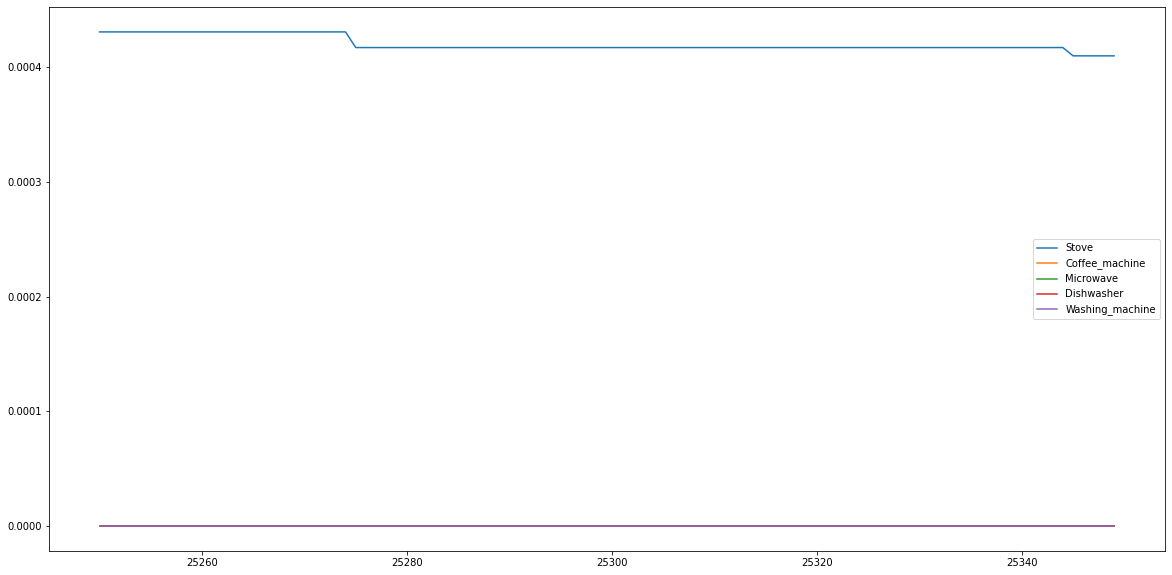

In [8]:
## why coffee machines dont work well
df.iloc[25250:25350].plot(y=appliances, figsize=(20, 10))

# Convert time series data to windowed data frame

In [9]:
window_size = 180
step = 1

In [10]:
windowed_data_path = f"{DATA_PATH}/windowed_{window_size}_step_{step}_noisy.csv"

In [11]:
df_timeseries = utils.write_or_load_windows(
    windowed_data_path, df, window_size, step, appliances
)
df_timeseries

Loading existing window file data/test/windowed_180_step_1_noisy.csv


,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68,sample_69,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_80,sample_81,sample_82,sample_83,sample_84,sample_85,sample_86,sample_87,sample_88,sample_89,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100,sample_101,sample_102,sample_103,sample_104,sample_105,sample_106,sample_107,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_120,sample_121,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_140,sample_141,sample_142,sample_143,sample_144,sample_145,sample_146,sample_147,sample_148,sample_149,sample_150,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,sample_161,sample_162,sample_163,sample_164,sample_165,sample_166,sample_167,sample_168,sample_169,sample_170,sample_171,sample_172,sample_173,sample_174,sample_175,sample_176,sample_177,sample_178,sample_179,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
0,0.0000472315,0.0000453972,0.0000473517,0.0000453586,0.0000454614,0.0000485080,0.0000479577,0.0000466298,0.0000473019,0.0000462348,0.0000465549,0.0000472695,0.0000453912,0.0000444484,0.0000453770,0.0000469510,0.0000457064,0.0000442620,0.0000434221,0.0000453886,0.0000451688,0.0000461576,0.0000419241,0.0000466182,0.0000467132,0.0000470272,0.0000450980,0.0000466102,0.0000459478,0.0000465695,0.0000459636,0.0000483252,0.0000441156,0.0000482241,0.0000451017,0.0000459436,0.0000434255,0.0000457474,0.0000435522,0.0000490150,0.0000474629,0.0000477814,0.0000442273,0.0000454035,0.0000436886,0.0000461738,0.0000481037,0.0000469560,0.0000460556,0.0000462457,0.0000435077,0.0000445934,0.0000446956,0.0000463042,0.0000475777,0.0000463528,0.0000471909,0.0000462264,0.0000455520,0.0000448661,0.0000468034,0.0000458701,0.0000445694,0.0000469979,0.0000432209,0.0000482912,0.0000463374,0.0000453449,0.0000466315,0.0000442781,0.0000450167,0.0000429562,0.0000448146,0.0000468605,0.0000453047,0.0000438172,0.0000464089,0.0000459434,0.0000465274,0.0000443679,0.0000472340,0.0000464945,0.0000447559,0.0000437363,0.0000456426,0.0000445840,0.0000445946,0.0000440609,0.0000470115,0.0000455820,0.0000449558,0.0000449073,0.0000441543,0.0000461654,0.0000458211,0.0000494487,0.0000450399,0.0000445947,0.0000456650,0.0000431215,0.0000442750,0.0000461750,0.0000425729,0.0000452951,0.0000450709,0.0000446376,0.0000434769,0.0000448001,0.0000448393,0.0000482766,0.0000462690,0.0000441186,0.0000461784,0.0000468750,0.0000454535,0.0000444246,0.0000470653,0.0000461288,0.0000463221,0.0000447024,0.0000444742,0.0000487407,0.0000484079,0.0000438742,0.0000439122,0.0000448091,0.0000432842,0.0000446974,0.0000431918,0.0000453788,0.0000473219,0.0000458088,0.0000477468,0.0000473041,0.0000462693,0.0000466196,0.0000452857,0.0000432897,0.0000460988,0.0000457752,0.0000468975,0.0000458260,0.0000443071,0.0000472455,0.0000459345,0.0000431515,0.0000461371,0.0000440717,0.0000436482,0.0000460972,0.0000451807,0.0000450294,0.0000458146,0.0000467235,0.0000463998,0.0000432572,0.0000454987,0.0000441871,0.0000459084,0.

# Train-test split

In [12]:
samples = [x for i, x in enumerate(df_timeseries.columns) if x not in appliances]
X = df_timeseries.loc[:, samples]
y = df_timeseries.loc[:, appliances]

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, shuffle=False
)

# Modeling

In [16]:
X_train.shape

(763653, 180)

In [17]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import AveragePooling1D, Conv1D, MaxPooling1D
from keras.models import Sequential

In [23]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [24]:
EPOCHS = 100
BATCH_SIZE = 32

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8, verbose=2, restore_best_weights=True
    ),
]

# Architecture insights
- Best model so far is true_DLO_doppelte_filter_60er_kernel_model with batch size 256, window size 180 with f1 scores between 88-96%, accuracy ~87% and LR at 5e-07
- GlobalMaxPooling seems to improve results on strongly imbalanced classes but worsens performance on "main" classes

In [39]:
from keras.layers import *


def create_model():
    kernel_size = 60
    filter_size = 128
    dropout = 0.3

    input_layer = keras.layers.Input(shape=(window_size, 1))

    conv1 = keras.layers.Conv1D(
        filters=filter_size, kernel_size=kernel_size, padding="same"
    )(input_layer)
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.MaxPool1D()(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Dropout(dropout)(conv1)

    conv2 = keras.layers.Conv1D(
        filters=filter_size, kernel_size=kernel_size, padding="same"
    )(conv1)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.MaxPool1D()(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Dropout(dropout)(conv2)

    conv3 = keras.layers.Conv1D(
        filters=filter_size, kernel_size=kernel_size, padding="same"
    )(conv2)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.MaxPool1D()(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Dropout(dropout)(conv3)

    #     conv4 = keras.layers.Conv1D(
    #         filters=filter_size, kernel_size=kernel_size, padding="same"
    #     )(conv3)
    #     conv4 = keras.layers.ReLU()(conv4)
    #     conv4 = keras.layers.MaxPool1D()(conv4)
    #     conv4 = keras.layers.BatchNormalization()(conv4)
    #     conv4 = keras.layers.Dropout(dropout)(conv4)

    #     conv5 = keras.layers.Conv1D(
    #         filters=filter_size, kernel_size=kernel_size, padding="same"
    #     )(conv4)
    #     conv5 = keras.layers.ReLU()(conv5)
    #     conv5 = keras.layers.BatchNormalization()(conv5)
    #     conv5 = keras.layers.Dropout(dropout)(conv5)

    gap = keras.layers.GlobalMaxPooling1D()(conv3)

    output_layer = keras.layers.Dense(len(appliances), activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [40]:
LR = 0.000008
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
f"Setting learning rate to {LR}"

'Setting learning rate to 8e-06'

In [41]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [42]:
model = create_model()

In [43]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["AUC", "binary_accuracy"])

In [44]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 1)]          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 180, 128)          7808      
                                                                 
 re_lu_10 (ReLU)             (None, 180, 128)          0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 90, 128)          0         
 1D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 90, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 90, 128)           0   

In [45]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
)

Epoch 1/100
23865/23865 [==============================] - 386s 16ms/step - loss: 0.1270 - auc: 0.9264 - binary_accuracy: 0.9538 - val_loss: 0.2000 - val_auc: 0.8839 - val_binary_accuracy: 0.9256 - lr: 8.0000e-06
Epoch 2/100
23865/23865 [==============================] - 373s 16ms/step - loss: 0.0967 - auc: 0.9588 - binary_accuracy: 0.9635 - val_loss: 0.1957 - val_auc: 0.8912 - val_binary_accuracy: 0.9271 - lr: 8.0000e-06
Epoch 3/100
23865/23865 [==============================] - 377s 16ms/step - loss: 0.0877 - auc: 0.9665 - binary_accuracy: 0.9668 - val_loss: 0.1967 - val_auc: 0.8951 - val_binary_accuracy: 0.9208 - lr: 8.0000e-06
Epoch 4/100
23865/23865 [==============================] - 366s 15ms/step - loss: 0.0818 - auc: 0.9709 - binary_accuracy: 0.9690 - val_loss: 0.1979 - val_auc: 0.8689 - val_binary_accuracy: 0.9292 - lr: 8.0000e-06
Epoch 5/100
23865/23865 [==============================] - 338s 14ms/step - loss: 0.0777 - auc: 0.9740 - binary_accuracy: 0.9705 - val_loss: 0.2033 

In [54]:
THRESHOLD = 0.5
y_pred = model.predict(X_test)
y_pred[y_pred >= THRESHOLD] = 1
y_pred[y_pred < THRESHOLD] = 0
y_pred

7019/7019 [==============================] - 23s 3ms/step


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [55]:
test_loss, test_auc, test_acc = model.evaluate(X_test, y_test)

print("Test AUC", test_auc)
print("Test Acc", test_acc)
print("Test loss", test_loss)

7019/7019 [==============================] - 39s 6ms/step - loss: 0.0987 - auc: 0.9583 - binary_accuracy: 0.9638
Test AUC 0.9583308696746826
Test Acc 0.963759183883667
Test loss 0.09866975992918015


In [56]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8599318804122793

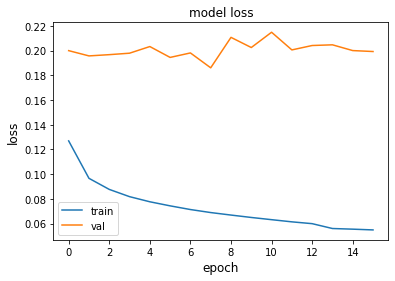

In [57]:
metric = "auc"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.savefig(f"{MODEL_PATH}/{MODEL_NAME}/LR={LR},Epochs={EPOCHS},BATCH={BATCH_SIZE}")
plt.show()
plt.close()

In [58]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred)

print(
    classification_report(y_test, y_pred, target_names=appliances, zero_division=False)
)

                 precision    recall  f1-score   support

          Stove       0.81      0.88      0.84     18066
 Coffee_machine       0.65      0.90      0.75      2482
      Microwave       0.31      0.64      0.42      2570
     Dishwasher       0.49      0.31      0.38     19558
Washing_machine       0.48      0.47      0.48      8584

      micro avg       0.61      0.58      0.59     51260
      macro avg       0.55      0.64      0.57     51260
   weighted avg       0.60      0.58      0.58     51260
    samples avg       0.10      0.11      0.10     51260



Accuracy: 0.9732775316667037


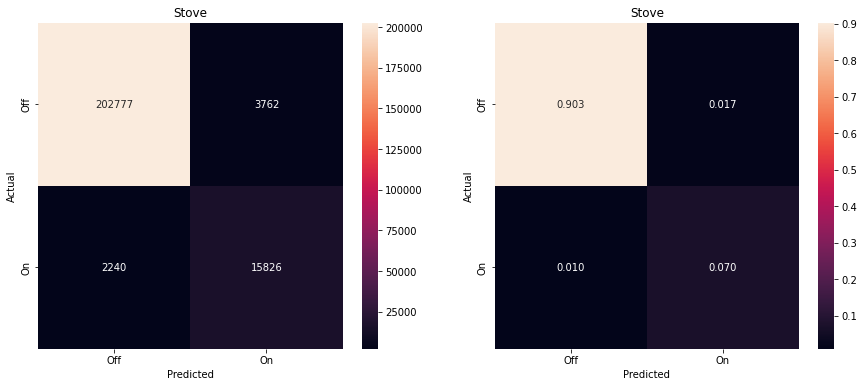

Accuracy: 0.9935664833819372


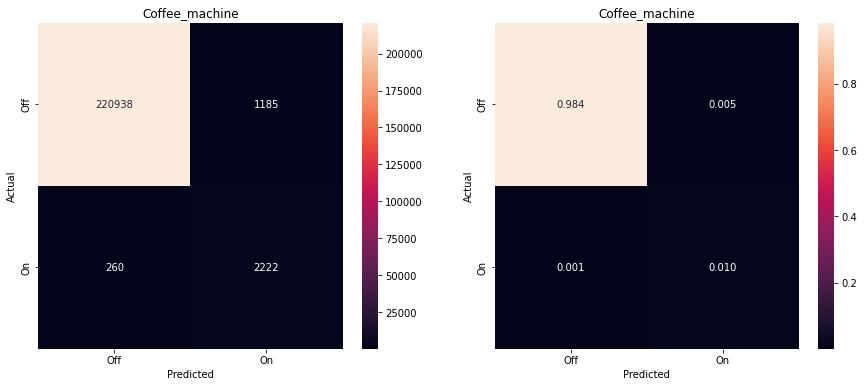

Accuracy: 0.979808998018744


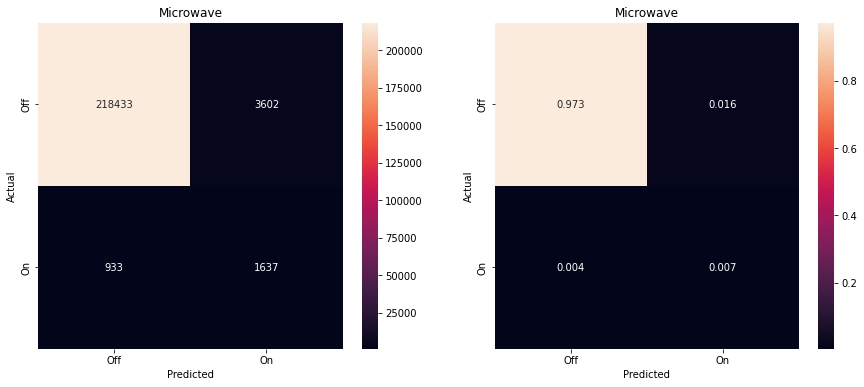

Accuracy: 0.9119832595000111


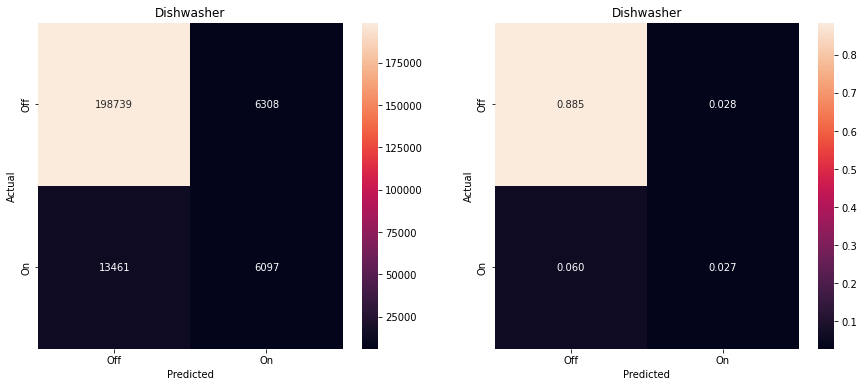

Accuracy: 0.9601522673137285


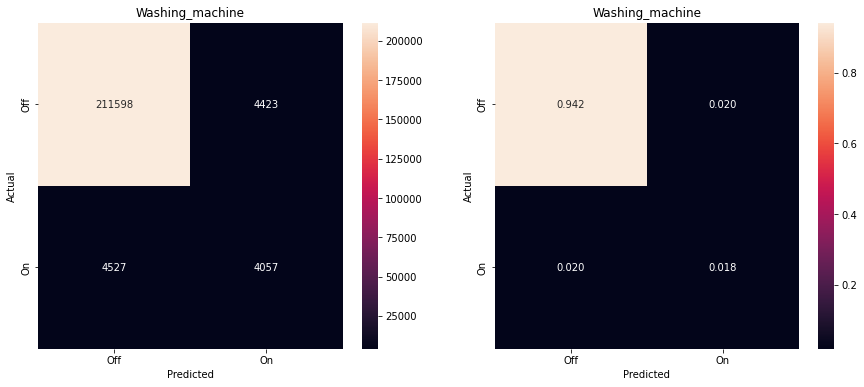

In [59]:
columns = ["Off", "On"]
for idx, item in enumerate(mcm):
    tn, fp, fn, tp = item.ravel()
    print(f"Accuracy: {(tp+tn)/(tn+fp+fn+tp)}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    heat = sns.heatmap(
        item, annot=True, fmt="1", xticklabels=columns, yticklabels=columns, ax=ax1
    )
    norm_item = item.astype("float") / item.sum(axis=None)
    norm_heat = sns.heatmap(
        norm_item,
        annot=True,
        fmt=".3f",
        xticklabels=columns,
        yticklabels=columns,
        ax=ax2,
    )
    for ax in [ax1, ax2]:
        ax.set_title(appliances[idx])
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.show()